In [1]:
import numpy as np

# Import Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

np.set_printoptions(threshold=np.inf) # print the whole matrix

In [2]:
# Nomenclature taken from paper
E_CNT = 6
A_CNT = 3
OUT_CNT = 1 # always has to be zero but just to make it be clean

In [3]:
e = QuantumRegister(E_CNT, 'e')
a = QuantumRegister(A_CNT, 'a')
out = QuantumRegister(OUT_CNT, 'out')
cbits = ClassicalRegister(E_CNT, 'cbits')
qc = QuantumCircuit(e, a, out, cbits)

qc.h(e)
qc.x(a)
qc.x(out)
qc.h(out)

def add_toffoli_gates(ctrl_idx_list, targ_idx):
    indices = ctrl_idx_list + [targ_idx]

    ctrls_qubits = []
    targ_qubit = 0
    for idx in indices:
        if idx != indices[-1]:
            if idx < E_CNT:
                ctrls_qubits.append(e[idx])
            elif idx == E_CNT+A_CNT+OUT_CNT-1:
                ctrls_qubits.append(out)
            else:
                ctrls_qubits.append(a[idx-E_CNT])
        else:
            if idx < E_CNT:
                targ_qubit = e[idx]
            elif idx == E_CNT+A_CNT+OUT_CNT-1:
                targ_qubit = out
            else:
               targ_qubit = a[idx-E_CNT]

    qc.mcx(ctrls_qubits, targ_qubit)

def add_not_gates(indices):
    x_qubits = []
    for idx in indices:
        if idx < E_CNT:
            x_qubits.append(e[idx])
        elif idx == E_CNT+A_CNT+OUT_CNT-1:
            x_qubits.append(out)
        else:
            x_qubits.append(a[idx-E_CNT])
    
    qc.x(x_qubits)

def apply_diffusion_operator():
    qc.h(e)
    qc.x(e)
    qc.h(e[E_CNT-1])
    qc.mcx(e[0:E_CNT-1], E_CNT-1)
    qc.h(e[E_CNT-1])
    qc.barrier(e)
    qc.x(e)
    qc.h(e)

add_toffoli_gates([0,1,4,5], 6)
add_toffoli_gates([2,3,4,5], 8)
add_not_gates([2,3,4,5])
add_toffoli_gates([0,1,2,3], 7)
add_toffoli_gates([2,3,4,5], 8)
mid_toffoli_ctrls = [0,6,7,8]
mid_toffoli_main_ctrl = 9
add_toffoli_gates(mid_toffoli_ctrls, mid_toffoli_main_ctrl)
add_toffoli_gates([2,3,4,5], 8)
add_toffoli_gates([0,1,2,3], 7)
add_not_gates([2,3,4,5])
add_toffoli_gates([2,3,4,5], 8)
add_toffoli_gates([0,1,4,5], 6)

apply_diffusion_operator()

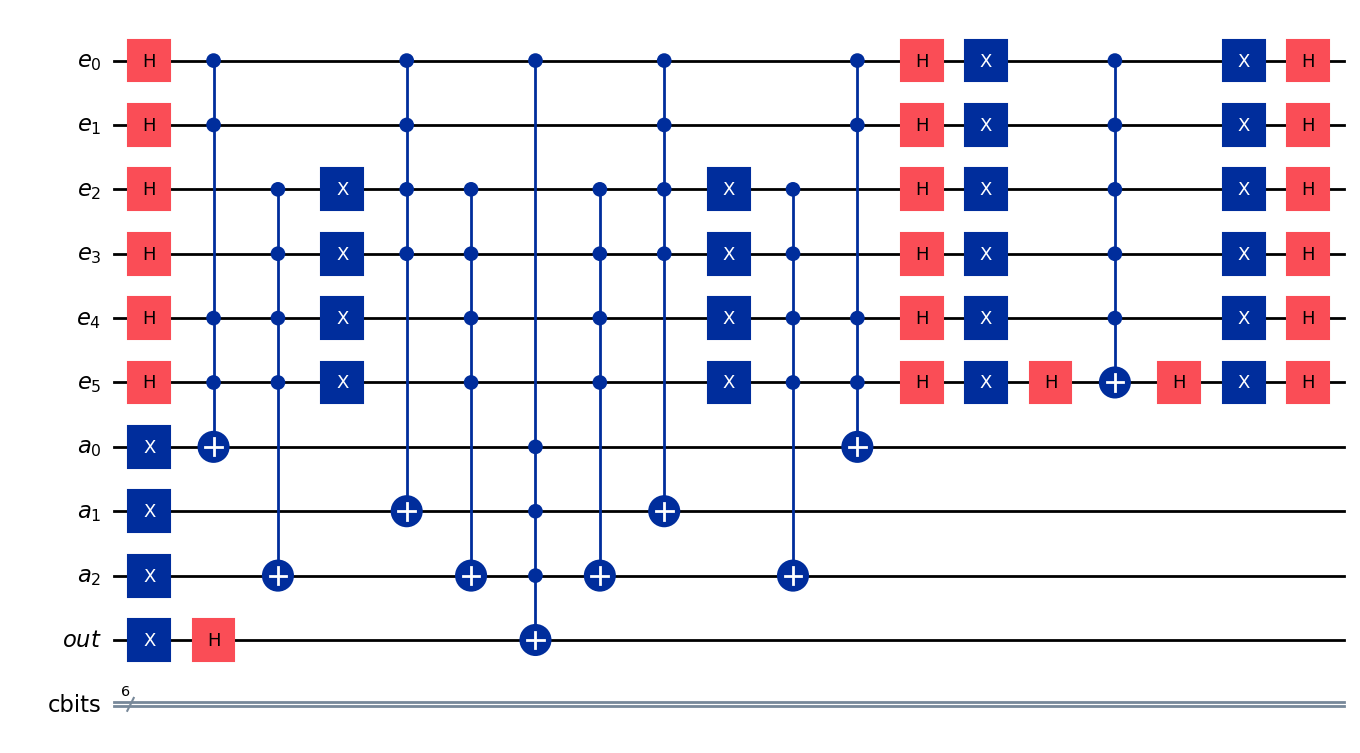

In [4]:
qc.draw('mpl', plot_barriers=False)

In [5]:
def to_pure_matrix(matrix):
    # get rid of floating point error
    # change -0.0 to 0.0
    return np.around(matrix, 10) + 0.

# Version 1 Normal Qiskit qubit ordering

[0.0162587 +0.j 0.0162587 +0.j 0.0162587 +0.j 0.0162587 +0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.0162587 +0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.0162587 +0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.20738138+0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.0162587 +0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.0162587 +0.j
 0.0162587 +0.j 0.20738138+0.j 0.0162587 +0.j 0.0162587 +0.j
 0.0162587 +0.j 0.0162587 +0.j 0.0162587 +0.j 0.0162587 +0.j]
1.000000000000001
Peak 

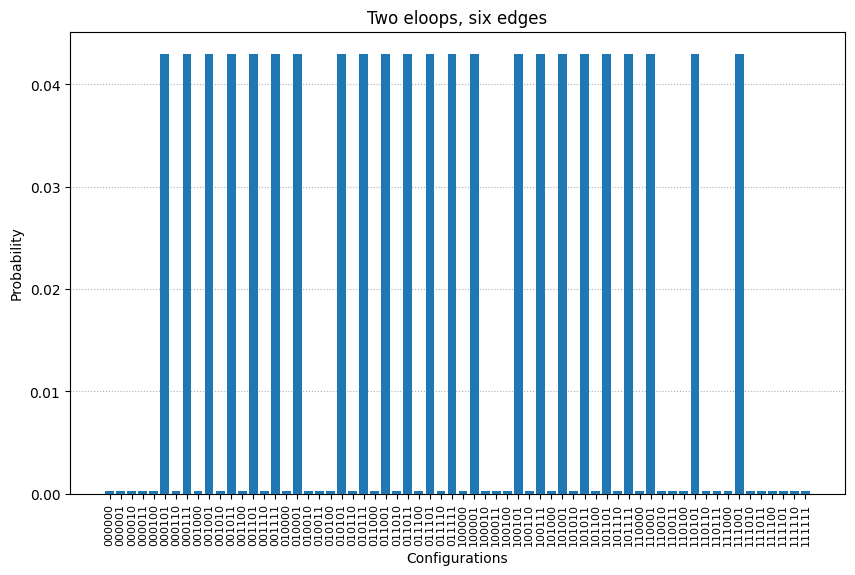

In [6]:
# qc.barrier()
# qc.measure(e, cbits)
# qc.draw('mpl', plot_barriers=False)

qc.save_statevector()
# Transpile for simulator
simulator = AerSimulator(method='statevector')
circ = transpile(qc, simulator)
# Run and get statevector
# result = simulator.run(circ).result()
result = simulator.run(circ).result()
statevector = result.get_statevector()

from qiskit.quantum_info import partial_trace

# trace out the auxilary and out qubits to only get the statevector of e register
partial_density_matrix = to_pure_matrix(np.diagonal(partial_trace(statevector, [i for i in range(E_CNT, E_CNT+A_CNT+OUT_CNT)])))

statevec = np.asarray(partial_density_matrix)

statevec = statevec / np.linalg.norm(statevec)

print(statevec)

import matplotlib.pyplot as plt


binary_states = [format(i, '0{}b'.format(int(len(statevec).bit_length() - 1))) for i in range(len(statevec))]
probabilities = [abs(x)**2 for x in statevec]

# sanity check
sum = 0
for prob in probabilities:
    sum += prob
print(sum)

cnt = 0
for p in probabilities:
    if p >= 0.02:
        cnt += 1

print("Peak count:", cnt)

# plot histogram
plt.figure(figsize=(10, 6))
plt.grid(axis='y', linestyle='dotted', zorder=0)
plt.title('Two eloops, six edges')
plt.xlabel('Configurations')
plt.ylabel('Probability')
plt.xticks(rotation=90, fontsize=8)
plt.bar(binary_states, probabilities, zorder=3)
plt.show()